## Predicting the cost of health insurance for a person

The important insurance company 4Geeks Insurance S.L. wants to calculate, based on the physiological data of its customers what will be the premium (cost) to be borne by each of them. To do this, it has assembled a whole team of doctors, and based on data from other companies and a particular study, it has managed to gather a set of data to train a predictive model.

### Step 0: Import Libreries

In [39]:
# Libreries
import pandas as pd

# When you work locally it is likely to have an error with the SSL certification
# Recomend use request for read csv
import requests
from io import StringIO

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,
                             r2_score)
from sklearn.feature_selection import (SelectKBest, 
                                       f_regression)


### Step 1: Get Data Base

In [3]:
# Import DB
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Create DB file in data/raw
df_raw = data.copy()
df_raw.to_csv("../data/raw/df_raw.csv", index= False)

In [5]:
display(df_raw.info())
display(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Step 2: Preprocessing

In [6]:
# Create df_interim
df_interim = (
    df_raw
        .copy()
        .set_axis(
            df_raw.columns.str.replace(' ','_')
                          .str.replace('r\W', '', regex= True)
                          .str.lower()
                          .str.slice(0, 40), axis= 1
        )
        .drop_duplicates().reset_index(drop= True)
        .rename(columns= {'charges': 'target'})
        .astype({'sex': 'category',
                 'smoker': 'category',
                 'region': 'category'
                 })
)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   target    1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [7]:
df_interim.to_csv('../data/interim/df_interim.csv', index= False)

### Step 3: EDA

In [8]:
df = df_interim.copy()
df_train, df_test = train_test_split(df, test_size= 0.2, random_state= 2024)

In [9]:
display(df_train.describe(include= 'number').T)
display(df_train.describe(include= 'category').T)

,count,mean,std,min,25%,50%,75%,max
age,1069.0,39.357343,14.062444,18.0000,27.0000,39.00000,51.0000,64.00000
bmi,1069.0,30.668363,6.159991,15.9600,26.2200,30.30500,34.8000,53.13000
children,1069.0,1.101964,1.200767,0.0000,0.0000,1.00000,2.0000,5.00000
target,1069.0,13541.821497,12334.388474,1121.8739,4753.6368,9541.69555,17043.3414,63770.42801


,count,unique,top,freq
sex,1069,2,male,535
smoker,1069,2,no,844
region,1069,4,southeast,287


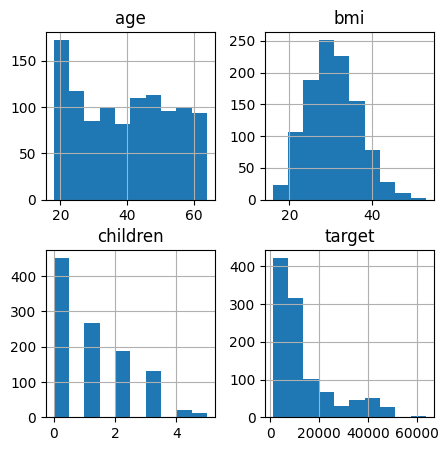

In [10]:
# Step 3.1: Univariate analysis
df_train.hist(figsize= (5, 5))
plt.show()

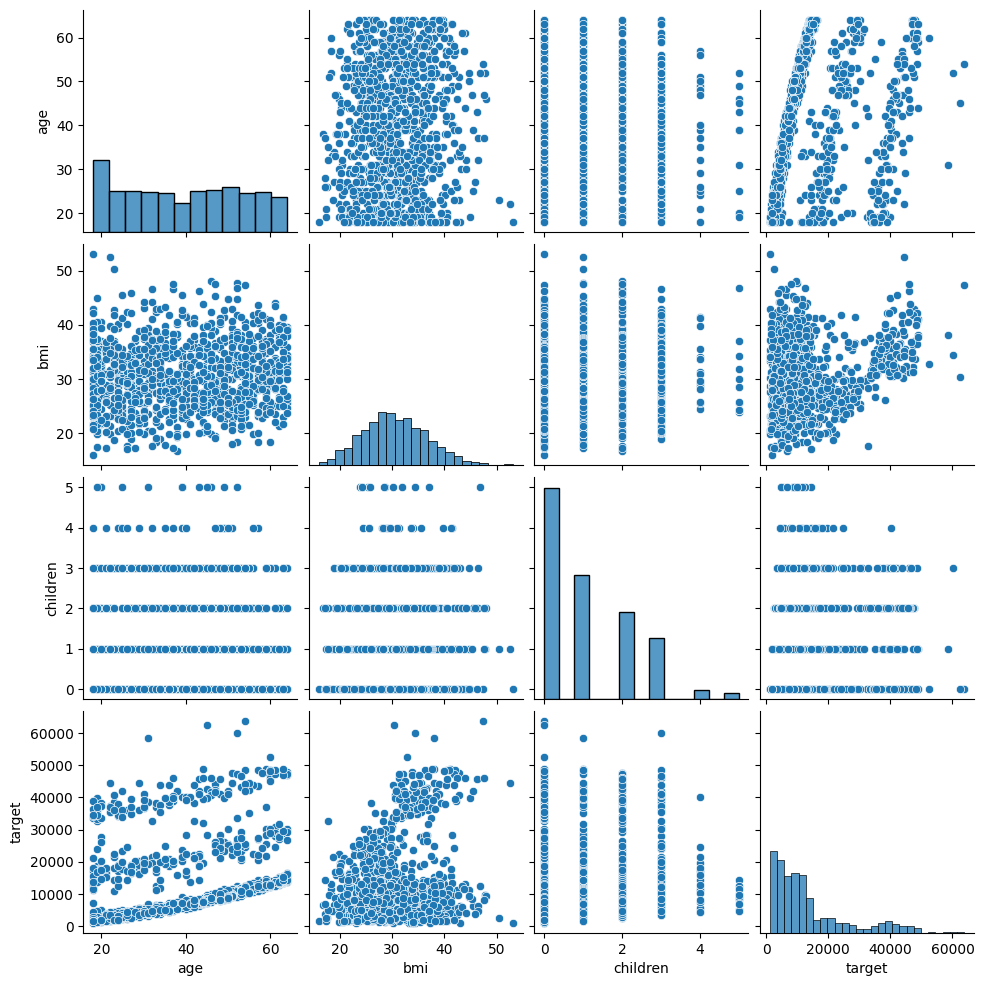

In [11]:
# Step 3.2: Bivariate analysis
sns.pairplot(data= df_train)
plt.show()

In [12]:
df_train.select_dtypes('number').corr()

,age,bmi,children,target
age,1.000000,0.091820,0.034826,0.291914
bmi,0.091820,1.000000,0.012397,0.227349
children,0.034826,0.012397,1.000000,0.071943
target,0.291914,0.227349,0.071943,1.000000


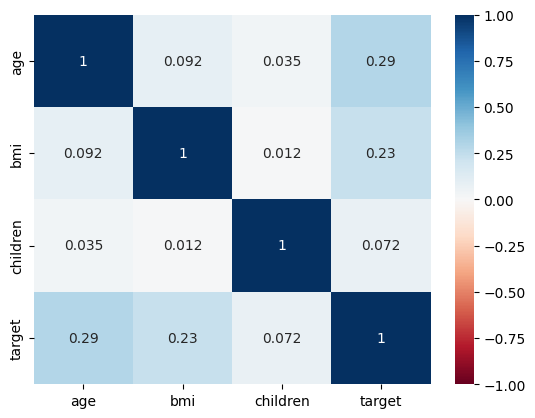

In [13]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap= 'RdBu')
plt.show()

In [14]:
# Min-Max Scaler
df_train['sex_n'] = pd.factorize(df_train['sex'])[0]
df_train['smoker_n'] = pd.factorize(df_train['smoker'])[0]
df_train['region_n'] = pd.factorize(df_train['region'])[0]
num_variables = ['age', 'bmi', 'children', 'sex_n', 'smoker_n', 'region_n', 'target']

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df_train[num_variables])
df_train_scal = pd.DataFrame(scal_features, index= df_train.index, columns= num_variables)
display(df_train_scal.head())

df_test['sex_n'] = pd.factorize(df_test['sex'])[0]
df_test['smoker_n'] = pd.factorize(df_test['smoker'])[0]
df_test['region_n'] = pd.factorize(df_test['region'])[0]
num_variables_test = ['age', 'bmi', 'children', 'sex_n', 'smoker_n', 'region_n', 'target']

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df_test[num_variables])
df_test_scal = pd.DataFrame(scal_features, index= df_test.index, columns= num_variables)
display(df_test_scal.head())

,age,bmi,children,sex_n,smoker_n,region_n,target
1286,0.391304,0.267420,0.2,0.0,0.0,0.000000,0.069444
403,0.673913,0.439602,0.6,1.0,0.0,0.333333,0.146014
1334,0.000000,0.562012,0.0,0.0,0.0,0.666667,0.008108
583,0.021739,0.127522,0.0,1.0,0.0,0.000000,0.001930
385,0.021739,0.496099,0.0,1.0,0.0,0.000000,0.002234


,age,bmi,children,sex_n,smoker_n,region_n,target
864,0.478261,0.405799,0.4,0.0,0.0,0.000000,0.101013
869,0.695652,0.601178,0.0,0.0,0.0,0.000000,0.135418
355,0.608696,0.334470,0.0,0.0,0.0,0.000000,0.434467
1188,0.108696,0.346875,0.0,1.0,0.0,0.000000,0.221896
20,0.913043,0.595131,0.0,1.0,0.0,0.333333,0.223789


In [15]:
# Start model
X_train = df_train_scal.drop('target', axis= 1).reset_index(drop= True)
y_train = df_train_scal['target'].reset_index(drop= True)
X_test = df_test_scal.drop('target', axis= 1).reset_index(drop= True)
y_test = df_test_scal['target'].reset_index(drop= True)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1069 non-null   float64
 1   bmi       1069 non-null   float64
 2   children  1069 non-null   float64
 3   sex_n     1069 non-null   float64
 4   smoker_n  1069 non-null   float64
 5   region_n  1069 non-null   float64
dtypes: float64(6)
memory usage: 50.2 KB


In [17]:
select_model = SelectKBest(f_regression, k= 4)
select_model.fit(X_train, y_train)

selected_columns = X_train.columns[select_model.get_support()]
X_train_sel = pd.DataFrame(select_model.transform(X_train), columns= selected_columns)
X_test_sel = pd.DataFrame(select_model.transform(X_test), columns= selected_columns)

display(X_train_sel.head())
display(X_test_sel.head())

,age,bmi,children,smoker_n
0,0.391304,0.267420,0.2,0.0
1,0.673913,0.439602,0.6,0.0
2,0.000000,0.562012,0.0,0.0
3,0.021739,0.127522,0.0,0.0
4,0.021739,0.496099,0.0,0.0


,age,bmi,children,smoker_n
0,0.478261,0.405799,0.4,0.0
1,0.695652,0.601178,0.0,0.0
2,0.608696,0.334470,0.0,0.0
3,0.108696,0.346875,0.0,0.0
4,0.913043,0.595131,0.0,0.0


In [18]:
X_train_sel["target"] = y_train.values
X_test_sel["target"] = y_test.values
X_train_sel.to_csv("../data/processed/df_train_scal.csv", index = False)
X_test_sel.to_csv("../data/processed/df_test_scal.csv", index = False)

### Regresion lineal model

Now we have the df clean and we can work with the 4 selected variables

In [32]:
df_train = pd.read_csv("../data/processed/df_train_scal.csv")
df_test = pd.read_csv("../data/processed/df_test_scal.csv")

df_train.head()

,age,bmi,children,smoker_n,target
0,0.391304,0.267420,0.2,0.0,0.069444
1,0.673913,0.439602,0.6,0.0,0.146014
2,0.000000,0.562012,0.0,0.0,0.008108
3,0.021739,0.127522,0.0,0.0,0.001930
4,0.021739,0.496099,0.0,0.0,0.002234


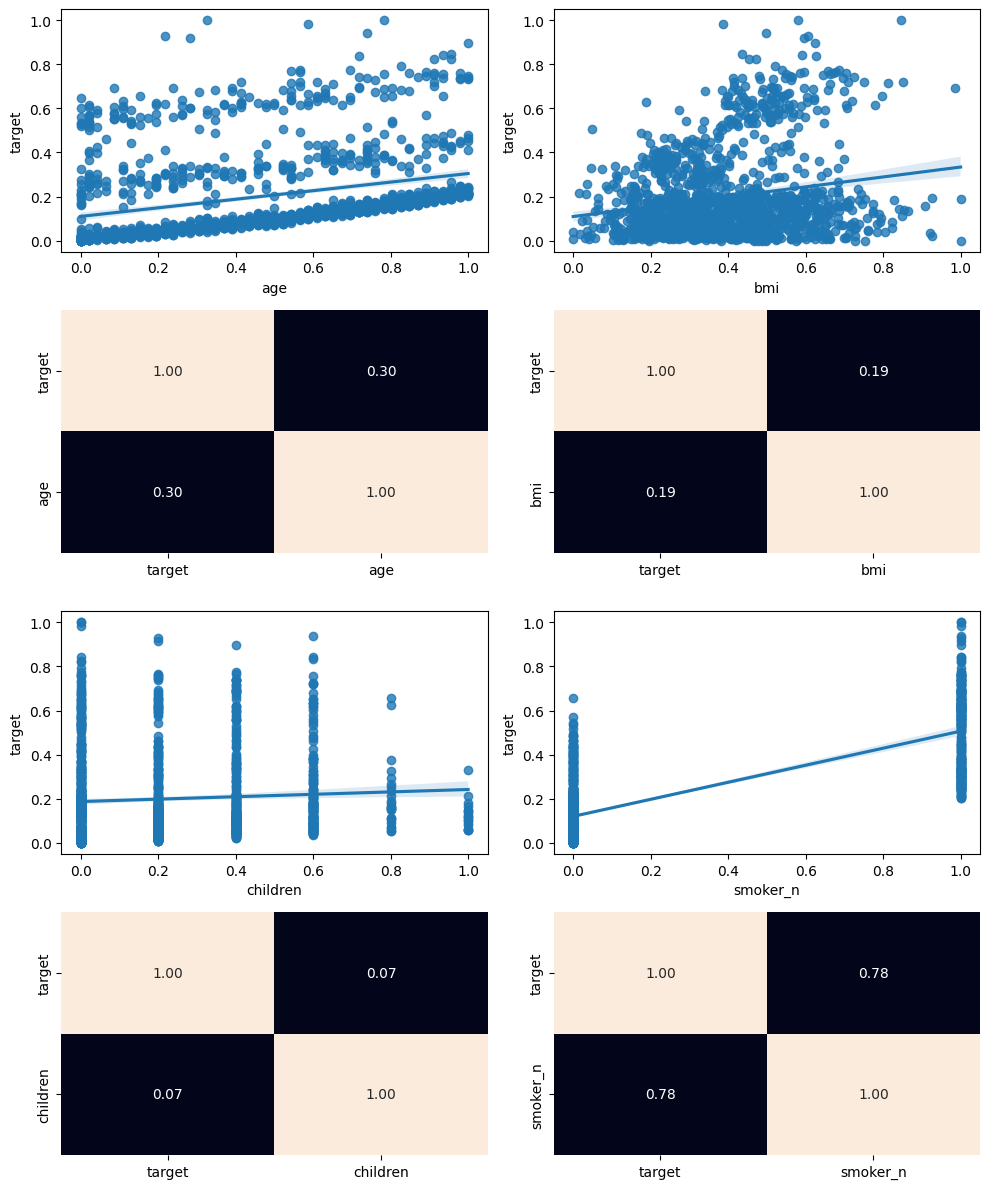

In [22]:
fig, ax = plt.subplots(4, 2, figsize= (10, 12))
df_train_scal = pd.concat([df_train, df_test])

sns.regplot(data = df_train_scal, x= 'age', y= 'target', ax= ax[0, 0])
sns.heatmap(df_train_scal[['target', 'age']].corr(), annot= True, fmt= '.2f', ax= ax[1, 0], cbar= False)

sns.regplot(data = df_train_scal, x= 'bmi', y= 'target', ax= ax[0, 1])
sns.heatmap(df_train_scal[['target', 'bmi']].corr(), annot= True, fmt= '.2f', ax= ax[1, 1], cbar= False)

sns.regplot(data = df_train_scal, x= 'children', y= 'target', ax= ax[2, 0])
sns.heatmap(df_train_scal[['target', 'children']].corr(), annot= True, fmt= '.2f', ax= ax[3, 0], cbar= False)

sns.regplot(data = df_train_scal, x= 'smoker_n', y= 'target', ax= ax[2, 1])
sns.heatmap(df_train_scal[['target', 'smoker_n']].corr(), annot= True, fmt= '.2f', ax= ax[3, 1], cbar= False)

plt.tight_layout()
plt.show()

In [33]:
X_train = df_train.drop(["target"], axis = 1)
y_train = df_train["target"]
X_test = df_test.drop(["target"], axis = 1)
y_test = df_test["target"]

In [34]:
X_train.head()

,age,bmi,children,smoker_n
0,0.391304,0.267420,0.2,0.0
1,0.673913,0.439602,0.6,0.0
2,0.000000,0.562012,0.0,0.0
3,0.021739,0.127522,0.0,0.0
4,0.021739,0.496099,0.0,0.0


In [35]:
# Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
print(f"Intercep (a): {model.intercept_}")
print(f"Coefficients (b1, b2): {model.coef_}")

Intercep (a): -0.05971717077087074
Coefficients (b1, b2): [0.19163708 0.19950693 0.04121112 0.38465641]


In [38]:
y_pred = model.predict(X_test)
y_pred

array([ 1.29379576e-01,  1.93534851e-01,  1.23660660e-01,  3.03170081e-02,
        2.33988578e-01,  2.52849250e-01,  1.31291182e-01,  4.60578634e-01,
        2.37484339e-02,  1.44139199e-01,  1.52864226e-01,  1.22450004e-01,
        7.88379237e-02,  7.54274734e-02,  2.96778153e-02,  1.47105993e-02,
        5.35567057e-01,  4.91524627e-01,  1.10982716e-01,  2.16756007e-01,
       -2.71181126e-02,  2.35311696e-01,  1.69713822e-01,  5.15804609e-02,
        1.90694472e-01,  6.87082516e-02,  2.38000035e-01,  6.67083300e-02,
        1.69662300e-01,  9.08683916e-02,  5.19027167e-01,  7.32559736e-02,
        1.47669832e-01,  7.65277215e-02,  7.56487487e-02,  5.32556250e-01,
        1.69314869e-01,  1.85902362e-01,  1.67448467e-01,  4.00165494e-01,
        1.70992437e-01,  2.21170911e-01,  1.74463139e-01,  1.47047422e-01,
        2.85022434e-02,  2.49177157e-01, -2.18927826e-02,  1.01204266e-01,
        3.06430694e-01, -6.22864946e-03,  1.44985870e-01,  6.12343100e-01,
        5.76230064e-02,  

In [43]:
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

MSE: 0.01
R2 Score: 0.68


This Linear Regression model has no correlation between its variables. Another model should be used for improvement.